In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
adityajn105_flickr8k_path = kagglehub.dataset_download('adityajn105/flickr8k')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import pickle
import numpy as np
from tqdm import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

from nltk.translate.bleu_score import corpus_bleu
import re


In [ ]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'
IMAGE_DIR = os.path.join(BASE_DIR, 'Images')
CAPTION_FILE = os.path.join(BASE_DIR, 'captions.txt')


In [ ]:
# Load VGG16 without last classification layer
base_model = VGG16()
model_vgg = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

features = {}

for img_name in tqdm(os.listdir(IMAGE_DIR)):
    img_path = os.path.join(IMAGE_DIR, img_name)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    feature = model_vgg.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))


100%|██████████| 8091/8091 [45:10<00:00,  2.98it/s]


In [ ]:
with open(CAPTION_FILE, 'r') as f:
    next(f)
    captions_doc = f.read()

mapping = {}

for line in captions_doc.split('\n'):
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, caption = tokens[0].split('.')[0], " ".join(tokens[1:])
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)


In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()
            caption = re.sub(r'[^a-z ]', '', caption)
            caption = re.sub(r'\s+', ' ', caption)
            caption = 'startseq ' + " ".join([w for w in caption.split() if len(w) > 1]) + ' endseq'
            captions[i] = caption

clean(mapping)


In [ ]:
all_captions = [cap for caps in mapping.values() for cap in caps]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)


In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    while True:
        X1, X2, y = list(), list(), list()
        n = 0

        for key in data_keys:
            captions = mapping[key]

            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical(out_seq, num_classes=vocab_size)

                    X1.append(features[key][0])  # shape (4096,)
                    X2.append(in_seq)
                    y.append(out_seq)

            n += 1
            if n == batch_size:
                yield (np.array(X1), np.array(X2)), np.array(y)
                X1, X2, y = list(), list(), list()
                n = 0


In [ ]:
# Image branch
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Text branch
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 34, 256)   │  2,244,608 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4096)      │          0 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 34, 256)   │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 34)        │          0 │ input_layer_6[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │  1,048,832 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ dropout_3[0][0],  │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dense_3[0][0],    │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8768)      │  2,253,376 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,137,920 (23.41 MB)

 Trainable params: 6,137,920 (23.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
image_ids = list(mapping.keys())
train = image_ids[:int(len(image_ids)*0.9)]

epochs = 3 #20
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

model.save(os.path.join(WORKING_DIR, 'best_model.h5'))


113/113 ━━━━━━━━━━━━━━━━━━━━ 395s 3s/step - loss: 3.0047
113/113 ━━━━━━━━━━━━━━━━━━━━ 392s 3s/step - loss: 2.8697
113/113 ━━━━━━━━━━━━━━━━━━━━ 395s 3s/step - loss: 2.7825


In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)

        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return in_text


In [ ]:
test = image_ids[int(len(image_ids)*0.9):]

actual, predicted = list(), list()

for key in test:
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)

    actual.append([caption.split() for caption in captions])
    predicted.append(y_pred.split())

print("BLEU-1:", corpus_bleu(actual, predicted, weights=(1,0,0,0)))
print("BLEU-2:", corpus_bleu(actual, predicted, weights=(0.5,0.5,0,0)))


BLEU-1: 0.494338255173071
BLEU-2: 0.2964195263222665


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def generate_caption(image_name):
    # Extract image ID (remove .jpg)
    image_id = image_name.split('.')[0]

    # Full image path
    img_path = os.path.join(BASE_DIR, 'Images', image_name)

    # Load image
    image = Image.open(img_path)

    # Show actual captions
    print("\nActual Captions:")
    captions = mapping[image_id]
    for caption in captions:
        print("-", caption)

    # Predict caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)

    print("\nPredicted Caption:")
    print("-", y_pred)

    # Display image
    plt.imshow(image)
    plt.axis('off')
    plt.show()



Actual Captions:
- startseq brown dog chases the water from sprinkler on lawn endseq
- startseq brown dog plays with the hose endseq
- startseq brown dog running on lawn near garden hose endseq
- startseq dog is playing with hose endseq
- startseq large brown dog running away from the sprinkler in the grass endseq

Predicted Caption:
- startseq brown dog is running through the grass


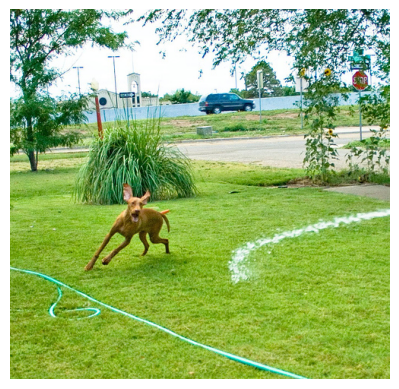

In [ ]:
generate_caption("1019077836_6fc9b15408.jpg")


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8k/Images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8k/Images/3097776588_312932e438.jpg
/kaggle/input/flickr8k/Images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8k/Images/1319634306_816f21677f.jpg
/kaggle/input/flickr8k/Images/2465218087_fca77998c6.jpg
/kaggle/input/flickr8k/Images/3351493005_6e5030f596.jpg
/kaggle/input/flickr8k/Images/2949337912_beba55698b.jpg
/kaggle/input/flickr8k/Images/534886684_a6c9f40fa1.jpg
/kaggle/input/flickr8k/Images/3543600125_223747ef4c.jpg
/kaggle/input/flickr8k/Images/2174206711_11cb712a8d.jpg
/kaggle/input/flickr8k/Images/280706862_14c30d734a.jpg
/kaggle/input/flickr8k/Images/2100735137_05c6079537.jpg
/kaggle/input/f